In [4]:
import pandas as pd
import numpy as np
from datetime import timedelta

In [5]:
pd.set_option("display.max_rows", 500)

In [6]:
df_dem = pd.read_csv("../data/Demographics/demographics.csv")
df_survey = pd.read_csv("../data/all_student_ema_data_cleaned (1).csv")
df_sens = pd.read_csv("../data/Sensing/sensing.csv")

In [7]:
df_survey["day"] = pd.to_datetime(df_survey["day"], format="%Y%m%d")
df_sens["day"] = pd.to_datetime(df_sens["day"], format="%Y%m%d")
df_survey = df_survey.drop(columns=["Unnamed: 0"])

In [8]:
df_sens["OS"] = df_sens.is_ios.apply(lambda x: "iOS" if x else "Android")

In [9]:
def calculate_cohort_year(date):
    if date.month >= 9:
        return date.year
    else:
        return date.year - 1


cohort_year = df_survey.groupby("uid")["day"].min().reset_index()
cohort_year.columns = ["uid", "first_day"]
cohort_year["cohort_year"] = (
    cohort_year["first_day"].apply(calculate_cohort_year).astype(int)
)
cohort_year = cohort_year.drop(columns=["first_day"])

In [10]:
cols = [
    "uid",
    "day",
    "OS",
    "is_ios",
    # physical
    "act_on_foot_ep_0",
    "act_running_ep_0",
    "act_walking_ep_0",
    "loc_study_dur",
    "loc_home_dur",
    "loc_workout_dur",
    # social
    "act_in_vehicle_ep_0",
    "loc_dist_ep_0",
    "loc_social_dur",
    "loc_food_dur",
    "loc_visit_num_ep_0",
    "loc_social_unlock_duration",
    "loc_food_unlock_duration",
    "loc_social_unlock_num",
    "loc_food_unlock_num",
    "loc_social_still",
    "loc_food_still",
    # sleep
    "sleep_duration",
    "sleep_start",
    "sleep_end",
]
df_sens = df_sens[cols].copy()

In [11]:
def sum_skipna(row, col1, col2):
    if np.isnan(row[col1]) and np.isnan(row[col2]):
        return np.nan
    elif np.isnan(row[col1]) and not np.isnan(row[col2]):
        return row[col2]
    elif not np.isnan(row[col1]) and np.isnan(row[col2]):
        return row[col1]
    else:
        return row[col1] + row[col2]

In [12]:
df_sens["24_minus_loc_home_dur"] = 24 - df_sens["loc_home_dur"]

df_sens["act_running_ep_0_plus_act_walking_ep_0"] = df_sens.apply(
    lambda x: sum_skipna(x, "act_running_ep_0", "act_walking_ep_0"), axis=1
)
df_sens["loc_social_dur_plus_loc_food_dur"] = df_sens.apply(
    lambda x: sum_skipna(x, "loc_social_dur", "loc_food_dur"), axis=1
)
df_sens["loc_social_unlock_duration_plus_loc_food_unlock_duration"] = (
    df_sens.apply(
        lambda x: sum_skipna(
            x, "loc_social_unlock_duration", "loc_food_unlock_duration"
        ),
        axis=1,
    )
)
df_sens["loc_social_unlock_num_plus_loc_food_unlock_num"] = df_sens.apply(
    lambda x: sum_skipna(x, "loc_social_unlock_num", "loc_food_unlock_num"),
    axis=1,
)
df_sens["loc_social_still_plus_loc_food_still"] = df_sens.apply(
    lambda x: sum_skipna(x, "loc_social_still", "loc_food_still"), axis=1
)
df_sens["act_on_foot_ep_0_or_act_running_ep_0_plus_act_walking_ep_0"] = (
    df_sens.loc[df_sens["OS"] == "Android", "act_on_foot_ep_0"]
)
df_sens["act_on_foot_ep_0_or_act_running_ep_0_plus_act_walking_ep_0"] = (
    df_sens.loc[
        df_sens["OS"] == "iOS", "act_running_ep_0_plus_act_walking_ep_0"
    ]
)

In [13]:
# check if sum_skipna works as intended
# df_sens[['loc_social_unlock_duration', 'loc_food_unlock_duration', 'loc_social_unlock_duration_plus_loc_food_unlock_duration']].head(100)

In [14]:
TK = 10

In [15]:
%%time
merged_list = []

for i, uid in enumerate(df_dem['uid'].unique()):
    # print(f"{i+1} / {len(df_dem['uid'].unique())}")
    df_survey_uid = df_survey[df_survey['uid'] == uid]
    df_sens_uid = df_sens[df_sens['uid'] == uid]

    df_merged = df_survey_uid.merge(df_sens_uid, how='cross', suffixes=('_survey', '_sens'))
    df_filtered = df_merged[
        (df_merged['day_sens'] >= df_merged['day_survey'] - timedelta(days=TK)) &
        (df_merged['day_sens'] <= df_merged['day_survey'] - timedelta(days=1))
    ]
    merged_list.append(df_filtered)


CPU times: user 10.7 s, sys: 1.12 ms, total: 10.7 s
Wall time: 10.7 s


In [16]:
df_merged = pd.concat(merged_list).reset_index(drop=True)

In [17]:
df_merged[["uid_survey", "uid_sens", "day_survey", "day_sens"]]

,uid_survey,uid_sens,day_survey,day_sens
0,3569e2f520db9014b4acc4227a6421c1,3569e2f520db9014b4acc4227a6421c1,2017-09-09,2017-09-08
1,3569e2f520db9014b4acc4227a6421c1,3569e2f520db9014b4acc4227a6421c1,2017-09-10,2017-09-08
2,3569e2f520db9014b4acc4227a6421c1,3569e2f520db9014b4acc4227a6421c1,2017-09-10,2017-09-09
3,3569e2f520db9014b4acc4227a6421c1,3569e2f520db9014b4acc4227a6421c1,2017-09-14,2017-09-08
4,3569e2f520db9014b4acc4227a6421c1,3569e2f520db9014b4acc4227a6421c1,2017-09-14,2017-09-09
...,...,...,...,...
337578,2c4f43b2212eee5ba69563f139911138,2c4f43b2212eee5ba69563f139911138,2020-12-24,2020-12-19
337579,2c4f43b2212eee5ba69563f139911138,2c4f43b2212eee5ba69563f139911138,2020-12-24,2020-12-20
337580,2c4f43b2212eee5ba69563f139911138,2c4f43b2212eee5ba69563f139911138,2020-12-24,2020-12-21
337581,2c4f43b2212eee5ba69563f139911138,2c4f43b2212eee5ba69563f139911138,2020-12-24,2020-12-22


In [18]:
df_merged["diff_days"] = df_merged.day_survey - df_merged.day_sens

In [19]:
df_merged.diff_days.value_counts()

diff_days
1 days     34520
2 days     34181
3 days     34007
4 days     33888
5 days     33788
6 days     33656
7 days     33542
8 days     33425
9 days     33347
10 days    33229
Name: count, dtype: int64

In [20]:
df_merged.head(1).T

,0
uid_survey,3569e2f520db9014b4acc4227a6421c1
day_survey,2017-09-09 00:00:00
pam,3
phq4_score,1
phq2_score,0
gad2_score,1
social_level,2
sse_score,16
stress,2
uid_sens,3569e2f520db9014b4acc4227a6421c1


In [21]:
number_cols = list(
    set(df_merged.columns)
    - set(["uid_survey", "day_survey", "uid_sens", "OS", "is_ios"])
)

In [22]:
df_grouped = df_merged.groupby(["uid_survey", "day_survey"])[
    number_cols
].mean()

In [23]:
df_grouped = df_grouped.reset_index()

In [24]:
df_grouped

,uid_survey,day_survey,loc_social_still,act_running_ep_0_plus_act_walking_ep_0,loc_workout_dur,loc_social_dur,24_minus_loc_home_dur,phq4_score,loc_food_unlock_num,sleep_start,...,loc_home_dur,loc_social_unlock_num_plus_loc_food_unlock_num,loc_food_unlock_duration,diff_days,act_in_vehicle_ep_0,sleep_end,loc_social_unlock_duration_plus_loc_food_unlock_duration,stress,phq2_score,act_on_foot_ep_0_or_act_running_ep_0_plus_act_walking_ep_0
0,003df5deff30e1e5a07b5d063fe85c3f,2017-10-06,51.271516,8396.2,0.000000,0.100056,16.149167,0.0,8.104227,39.6,...,7.850833,8.770523,12.981414,3 days 00:00:00,251.4,112.8,12.981969,1.0,0.0,8396.2
1,003df5deff30e1e5a07b5d063fe85c3f,2017-10-13,52.250667,12182.0,0.099861,0.294833,10.582500,0.0,6.468923,47.4,...,13.417500,7.336248,5.354113,5 days 12:00:00,125.7,92.0,6.255514,1.0,0.0,12182.0
2,003df5deff30e1e5a07b5d063fe85c3f,2017-10-14,52.250667,11753.9,0.099861,0.294833,10.907194,0.0,6.659753,45.4,...,13.092806,7.418661,4.793226,5 days 12:00:00,125.7,91.8,5.581952,1.0,0.0,11753.9
3,003df5deff30e1e5a07b5d063fe85c3f,2017-10-16,52.740242,13399.3,0.099861,0.244806,12.467167,0.0,5.613500,41.8,...,11.532833,6.195268,5.145072,5 days 12:00:00,1540.6,85.8,6.046236,1.0,0.0,13399.3
4,003df5deff30e1e5a07b5d063fe85c3f,2017-10-23,50.909477,11003.5,0.000000,0.239306,12.760889,0.0,9.161989,50.0,...,11.239111,12.130441,11.027101,5 days 12:00:00,1540.6,92.2,15.476544,2.0,0.0,11003.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34697,ffc4b142e017c162ed4db7b05414fc4b,2021-12-18,NaN,0.0,0.000000,0.000000,7.488736,0.0,NaN,39.2,...,16.511264,NaN,NaN,5 days 12:00:00,1703.6,91.2,NaN,2.0,0.0,NaN
34698,ffc4b142e017c162ed4db7b05414fc4b,2021-12-31,NaN,0.0,0.000000,0.000000,7.897945,0.0,NaN,54.6,...,16.102055,NaN,NaN,5 days 12:00:00,821.0,101.4,NaN,3.0,0.0,NaN
34699,ffc4b142e017c162ed4db7b05414fc4b,2022-01-27,52.440481,0.0,0.000000,0.479104,6.927733,1.0,6.578229,48.2,...,17.072267,8.703598,25.395577,5 days 12:00:00,13.9,99.0,36.099785,5.0,1.0,NaN
34700,ffc4b142e017c162ed4db7b05414fc4b,2022-01-30,50.523585,0.0,0.000000,0.462189,6.294530,0.0,9.844660,47.8,...,17.705470,13.130987,29.362945,5 days 12:00:00,18.9,99.2,41.777185,3.0,0.0,NaN


In [25]:
df = df_dem.merge(cohort_year, on="uid", how="outer")

In [26]:
df_dem

,uid,gender,race
0,3569e2f520db9014b4acc4227a6421c1,both,white
1,ac70fe1f8115ac361f2023269c011c3e,M,asian
2,3bb377ba0acb7d8916010184df36aa57,F,white
3,fa394f6d3d077bd5568fc3bc01580806,F,white
4,84120765740b5395aa49a2feb12fbb43,M,asian
5,f4d488e3c8096842b645280d8f01ae43,F,asian
6,79d8490ab94fc7cd6530b1f22593d708,F,white
7,3dad5f11680b432159b65838119ab87e,F,white
8,2b3d267f18830c3c257b382edabef246,M,white
9,46f1dfeda71a865074859c81bb314fd9,F,white


In [27]:
df.head()

,uid,gender,race,cohort_year
0,003df5deff30e1e5a07b5d063fe85c3f,F,asian,2017
1,0107c61e54459068bb83f6be2058d65d,F,white,2018
2,01fb41df0f6c2f69d65db5a38c600b4c,M,white,2017
3,031cf9537e5da78c5a69a10cba088c94,F,white,2017
4,03a0ce5623bfeb8aa3113605f7682215,F,more than one,2018


In [28]:
os = df_sens.loc[df_sens.groupby("uid")["day"].idxmin(), ["uid", "is_ios"]]
os["OS"] = os.is_ios.apply(lambda x: "iOS" if x else "Android")

In [29]:
df = df.merge(os, on="uid", how="outer")

In [30]:
df.head()

,uid,gender,race,cohort_year,is_ios,OS
0,003df5deff30e1e5a07b5d063fe85c3f,F,asian,2017.0,1,iOS
1,0107c61e54459068bb83f6be2058d65d,F,white,2018.0,1,iOS
2,01fb41df0f6c2f69d65db5a38c600b4c,M,white,2017.0,1,iOS
3,031cf9537e5da78c5a69a10cba088c94,F,white,2017.0,1,iOS
4,03a0ce5623bfeb8aa3113605f7682215,F,more than one,2018.0,1,iOS


In [31]:
df = df.merge(df_grouped, left_on="uid", right_on="uid_survey", how="outer")

In [32]:
df.head()

,uid,gender,race,cohort_year,is_ios,OS,uid_survey,day_survey,loc_social_still,act_running_ep_0_plus_act_walking_ep_0,...,loc_home_dur,loc_social_unlock_num_plus_loc_food_unlock_num,loc_food_unlock_duration,diff_days,act_in_vehicle_ep_0,sleep_end,loc_social_unlock_duration_plus_loc_food_unlock_duration,stress,phq2_score,act_on_foot_ep_0_or_act_running_ep_0_plus_act_walking_ep_0
0,003df5deff30e1e5a07b5d063fe85c3f,F,asian,2017.0,1,iOS,003df5deff30e1e5a07b5d063fe85c3f,2017-10-06,51.271516,8396.2,...,7.850833,8.770523,12.981414,3 days 00:00:00,251.4,112.8,12.981969,1.0,0.0,8396.2
1,003df5deff30e1e5a07b5d063fe85c3f,F,asian,2017.0,1,iOS,003df5deff30e1e5a07b5d063fe85c3f,2017-10-13,52.250667,12182.0,...,13.417500,7.336248,5.354113,5 days 12:00:00,125.7,92.0,6.255514,1.0,0.0,12182.0
2,003df5deff30e1e5a07b5d063fe85c3f,F,asian,2017.0,1,iOS,003df5deff30e1e5a07b5d063fe85c3f,2017-10-14,52.250667,11753.9,...,13.092806,7.418661,4.793226,5 days 12:00:00,125.7,91.8,5.581952,1.0,0.0,11753.9
3,003df5deff30e1e5a07b5d063fe85c3f,F,asian,2017.0,1,iOS,003df5deff30e1e5a07b5d063fe85c3f,2017-10-16,52.740242,13399.3,...,11.532833,6.195268,5.145072,5 days 12:00:00,1540.6,85.8,6.046236,1.0,0.0,13399.3
4,003df5deff30e1e5a07b5d063fe85c3f,F,asian,2017.0,1,iOS,003df5deff30e1e5a07b5d063fe85c3f,2017-10-23,50.909477,11003.5,...,11.239111,12.130441,11.027101,5 days 12:00:00,1540.6,92.2,15.476544,2.0,0.0,11003.5


In [33]:
df = df.drop(columns=["uid_survey"])

In [34]:
df.head()

,uid,gender,race,cohort_year,is_ios,OS,day_survey,loc_social_still,act_running_ep_0_plus_act_walking_ep_0,loc_workout_dur,...,loc_home_dur,loc_social_unlock_num_plus_loc_food_unlock_num,loc_food_unlock_duration,diff_days,act_in_vehicle_ep_0,sleep_end,loc_social_unlock_duration_plus_loc_food_unlock_duration,stress,phq2_score,act_on_foot_ep_0_or_act_running_ep_0_plus_act_walking_ep_0
0,003df5deff30e1e5a07b5d063fe85c3f,F,asian,2017.0,1,iOS,2017-10-06,51.271516,8396.2,0.000000,...,7.850833,8.770523,12.981414,3 days 00:00:00,251.4,112.8,12.981969,1.0,0.0,8396.2
1,003df5deff30e1e5a07b5d063fe85c3f,F,asian,2017.0,1,iOS,2017-10-13,52.250667,12182.0,0.099861,...,13.417500,7.336248,5.354113,5 days 12:00:00,125.7,92.0,6.255514,1.0,0.0,12182.0
2,003df5deff30e1e5a07b5d063fe85c3f,F,asian,2017.0,1,iOS,2017-10-14,52.250667,11753.9,0.099861,...,13.092806,7.418661,4.793226,5 days 12:00:00,125.7,91.8,5.581952,1.0,0.0,11753.9
3,003df5deff30e1e5a07b5d063fe85c3f,F,asian,2017.0,1,iOS,2017-10-16,52.740242,13399.3,0.099861,...,11.532833,6.195268,5.145072,5 days 12:00:00,1540.6,85.8,6.046236,1.0,0.0,13399.3
4,003df5deff30e1e5a07b5d063fe85c3f,F,asian,2017.0,1,iOS,2017-10-23,50.909477,11003.5,0.000000,...,11.239111,12.130441,11.027101,5 days 12:00:00,1540.6,92.2,15.476544,2.0,0.0,11003.5


In [35]:
df_features = df.copy()

In [36]:
df_features = df_features.rename(
    columns={
        "act_running_ep_0_plus_act_walking_ep_0": "P1",
        "loc_study_dur": "P2",
        "loc_home_dur": "P3",
        "loc_workout_dur": "P4",
        "act_in_vehicle_ep_0": "S1",
        "loc_dist_ep_0": "S2",
        "loc_social_dur_plus_loc_food_dur": "S3",
        "loc_visit_num_ep_0": "S4",
        "loc_social_unlock_duration_plus_loc_food_unlock_duration": "S5",
        "loc_social_unlock_num_plus_loc_food_unlock_num": "S6",
        "loc_social_still_plus_loc_food_still": "S7",
        "sleep_duration": "Z1",
        "sleep_start": "Z2",
        "sleep_end": "Z3",
    }
)[
    [
        "uid",
        "day_survey",
        "pam",
        "phq4_score",
        "phq2_score",
        "gad2_score",
        "social_level",
        "sse_score",
        "stress",
        # features
        "gender",
        "race",
        "OS",
        "cohort_year",
        "P1",
        "P2",
        "P3",
        "P4",
        "S1",
        "S2",
        "S3",
        "S4",
        "S5",
        "S6",
        "S7",
        "Z1",
        "Z2",
        "Z3",
    ]
]

In [37]:
pd.set_option("display.max_rows", 300)

In [38]:
df_features.head()

,uid,day_survey,pam,phq4_score,phq2_score,gad2_score,social_level,sse_score,stress,gender,...,S1,S2,S3,S4,S5,S6,S7,Z1,Z2,Z3
0,003df5deff30e1e5a07b5d063fe85c3f,2017-10-06,7.0,0.0,0.0,0.0,4.0,17.0,1.0,F,...,251.4,5314.150918,1.292778,5.75,12.981969,8.770523,56.938186,9.150,39.6,112.8
1,003df5deff30e1e5a07b5d063fe85c3f,2017-10-13,7.0,0.0,0.0,0.0,4.0,17.0,1.0,F,...,125.7,4846.948206,1.618000,5.40,6.255514,7.336248,65.683645,5.575,47.4,92.0
2,003df5deff30e1e5a07b5d063fe85c3f,2017-10-14,7.0,0.0,0.0,0.0,5.0,17.0,1.0,F,...,125.7,4713.753968,1.668028,5.40,5.581952,7.418661,62.666138,5.800,45.4,91.8
3,003df5deff30e1e5a07b5d063fe85c3f,2017-10-16,4.0,0.0,0.0,0.0,1.0,17.0,1.0,F,...,1540.6,43788.508496,1.305028,5.10,6.046236,6.195268,62.442725,5.500,41.8,85.8
4,003df5deff30e1e5a07b5d063fe85c3f,2017-10-23,1.0,0.0,0.0,0.0,3.0,17.0,2.0,F,...,1540.6,43090.361687,0.928583,4.80,15.476544,12.130441,60.148926,5.275,50.0,92.2


In [39]:
df_features.loc[df_features.OS == "Android"].head()

,uid,day_survey,pam,phq4_score,phq2_score,gad2_score,social_level,sse_score,stress,gender,...,S1,S2,S3,S4,S5,S6,S7,Z1,Z2,Z3
1150,0ba15aa0582c5e825710d42fe3eb231d,2018-11-17,14.0,1.0,1.0,0.0,2.0,8.0,5.0,F,...,56.000000,1355.703647,1.001512,3.666667,18.065432,16.410384,32.294395,11.666667,42.0,135.333333
1151,0ba15aa0582c5e825710d42fe3eb231d,2018-11-18,9.0,2.0,2.0,0.0,4.0,12.0,2.0,F,...,243.500000,5978.643535,0.751134,3.500000,18.065432,16.410384,32.294395,11.375000,45.5,136.500000
1152,0ba15aa0582c5e825710d42fe3eb231d,2018-11-21,9.0,1.0,1.0,0.0,3.0,16.0,2.0,F,...,2219.285714,327290.767731,0.512559,3.571429,23.326618,21.796608,32.110549,8.250000,48.0,114.000000
1153,0ba15aa0582c5e825710d42fe3eb231d,2018-11-24,14.0,0.0,0.0,0.0,4.0,17.0,1.0,F,...,2501.700000,238506.395743,0.358791,3.200000,23.326618,21.796608,32.110549,7.450000,44.2,103.800000
1154,0ba15aa0582c5e825710d42fe3eb231d,2018-11-25,15.0,0.0,0.0,0.0,2.0,14.0,1.0,F,...,2599.100000,238905.657260,0.358791,3.000000,23.326618,21.796608,32.110549,7.075000,48.6,105.200000


In [40]:
df_features.describe()

,day_survey,pam,phq4_score,phq2_score,gad2_score,social_level,sse_score,stress,cohort_year,P1,...,S1,S2,S3,S4,S5,S6,S7,Z1,Z2,Z3
count,34702,34702.000000,34702.000000,34702.000000,34702.000000,34702.000000,34702.000000,34702.000000,34704.000000,34702.000000,...,34702.000000,3.012300e+04,34549.000000,31174.000000,16311.000000,16311.000000,16311.000000,34702.000000,34702.000000,34702.000000
mean,2019-10-24 01:17:03.502968064,7.257219,2.300588,1.250101,1.049680,3.141001,13.047548,2.513198,2017.507089,8853.943547,...,2172.963473,1.644811e+05,0.795242,3.410162,12.506530,10.398949,60.427442,7.466230,40.166525,99.896365
min,2017-09-08 00:00:00,1.000000,0.000000,0.000000,0.000000,1.000000,4.000000,1.000000,2017.000000,0.000000,...,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,3.508197,2.375000,0.000000,46.000000
25%,2018-12-13 00:00:00,3.000000,0.000000,0.000000,0.000000,2.000000,11.000000,2.000000,2017.000000,3983.000000,...,288.000000,5.482391e+03,0.000000,1.800000,5.840247,5.559661,49.061972,6.375000,31.600000,92.200000
50%,2019-09-11 00:00:00,7.000000,2.000000,1.000000,0.000000,3.000000,13.000000,2.000000,2018.000000,9494.100000,...,1403.300000,2.257554e+04,0.000000,3.300000,10.337346,8.956803,58.986266,7.325000,39.600000,98.600000
75%,2020-09-07 00:00:00,10.000000,4.000000,2.000000,2.000000,4.000000,15.000000,3.000000,2018.000000,13267.450000,...,3344.650000,7.518150e+04,1.185583,4.900000,16.551765,13.589376,71.354850,8.200000,48.200000,105.400000
max,2022-06-25 00:00:00,16.000000,12.000000,6.000000,6.000000,5.000000,20.000000,5.000000,2018.000000,43029.500000,...,25374.300000,1.424216e+08,18.871861,11.300000,106.254921,84.765226,119.989475,23.750000,130.800000,190.000000
std,NaN,4.329509,2.620154,1.409380,1.436397,1.256929,3.191855,1.094712,0.499957,6157.978140,...,2387.247007,1.867988e+06,1.483201,1.915986,10.100110,7.356419,17.032139,2.049388,13.449629,12.974069


In [41]:
df_features_name = df_features.rename(
    columns={
        "P1": "average daily exercises",
        "P2": "studying time",
        "P3": "inside the house time",
        "P4": "doing sport",
        "S1": "time spent travelling",
        "S2": "distance travelled",
        "S3": "time spent at social location",
        "S4": "change of scenery",
        "S5": "phone unlocked duration while at social and food venues",
        "S6": "frequency of phone unlock while at social and food venues",
        "S7": "activity while at social and food venus",
        "Z1": "sleeping time",
        "Z2": "start sleeping time",
        "Z3": "end sleeping time",
    }
)

In [42]:
df_features_name.head(10)

,uid,day_survey,pam,phq4_score,phq2_score,gad2_score,social_level,sse_score,stress,gender,...,time spent travelling,distance travelled,time spent at social location,change of scenery,phone unlocked duration while at social and food venues,frequency of phone unlock while at social and food venues,activity while at social and food venus,sleeping time,start sleeping time,end sleeping time
0,003df5deff30e1e5a07b5d063fe85c3f,2017-10-06,7.0,0.0,0.0,0.0,4.0,17.0,1.0,F,...,251.4,5314.150918,1.292778,5.75,12.981969,8.770523,56.938186,9.150,39.6,112.8
1,003df5deff30e1e5a07b5d063fe85c3f,2017-10-13,7.0,0.0,0.0,0.0,4.0,17.0,1.0,F,...,125.7,4846.948206,1.618000,5.40,6.255514,7.336248,65.683645,5.575,47.4,92.0
2,003df5deff30e1e5a07b5d063fe85c3f,2017-10-14,7.0,0.0,0.0,0.0,5.0,17.0,1.0,F,...,125.7,4713.753968,1.668028,5.40,5.581952,7.418661,62.666138,5.800,45.4,91.8
3,003df5deff30e1e5a07b5d063fe85c3f,2017-10-16,4.0,0.0,0.0,0.0,1.0,17.0,1.0,F,...,1540.6,43788.508496,1.305028,5.10,6.046236,6.195268,62.442725,5.500,41.8,85.8
4,003df5deff30e1e5a07b5d063fe85c3f,2017-10-23,1.0,0.0,0.0,0.0,3.0,17.0,2.0,F,...,1540.6,43090.361687,0.928583,4.80,15.476544,12.130441,60.148926,5.275,50.0,92.2
5,003df5deff30e1e5a07b5d063fe85c3f,2017-10-31,1.0,0.0,0.0,0.0,4.0,17.0,2.0,F,...,0.0,3434.509460,1.416639,4.70,10.908447,10.161476,49.243283,5.800,57.6,104.0
6,003df5deff30e1e5a07b5d063fe85c3f,2017-11-07,3.0,0.0,0.0,0.0,1.0,17.0,2.0,F,...,2085.8,44654.076149,0.923361,4.70,14.069966,8.158529,50.392278,5.575,62.8,107.4
7,003df5deff30e1e5a07b5d063fe85c3f,2017-11-10,3.0,0.0,0.0,0.0,2.0,17.0,3.0,F,...,2085.8,45510.005289,1.371472,5.10,11.209928,8.220697,58.396907,4.850,64.2,103.0
8,003df5deff30e1e5a07b5d063fe85c3f,2017-11-18,4.0,1.0,1.0,0.0,1.0,17.0,3.0,F,...,91.9,5127.799288,1.936472,4.00,6.554888,6.406191,59.759086,4.600,68.0,104.8
9,003df5deff30e1e5a07b5d063fe85c3f,2017-11-19,3.0,1.0,1.0,0.0,4.0,17.0,1.0,F,...,91.9,4669.133793,1.753111,3.80,6.711956,6.593422,61.366224,4.700,69.0,106.6


In [43]:
df_features.columns

Index(['uid', 'day_survey', 'pam', 'phq4_score', 'phq2_score', 'gad2_score',
       'social_level', 'sse_score', 'stress', 'gender', 'race', 'OS',
       'cohort_year', 'P1', 'P2', 'P3', 'P4', 'S1', 'S2', 'S3', 'S4', 'S5',
       'S6', 'S7', 'Z1', 'Z2', 'Z3'],
      dtype='object')

In [44]:
df_features.to_csv("features.csv", index=False)

In [45]:
df_features.describe()

,day_survey,pam,phq4_score,phq2_score,gad2_score,social_level,sse_score,stress,cohort_year,P1,...,S1,S2,S3,S4,S5,S6,S7,Z1,Z2,Z3
count,34702,34702.000000,34702.000000,34702.000000,34702.000000,34702.000000,34702.000000,34702.000000,34704.000000,34702.000000,...,34702.000000,3.012300e+04,34549.000000,31174.000000,16311.000000,16311.000000,16311.000000,34702.000000,34702.000000,34702.000000
mean,2019-10-24 01:17:03.502968064,7.257219,2.300588,1.250101,1.049680,3.141001,13.047548,2.513198,2017.507089,8853.943547,...,2172.963473,1.644811e+05,0.795242,3.410162,12.506530,10.398949,60.427442,7.466230,40.166525,99.896365
min,2017-09-08 00:00:00,1.000000,0.000000,0.000000,0.000000,1.000000,4.000000,1.000000,2017.000000,0.000000,...,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,3.508197,2.375000,0.000000,46.000000
25%,2018-12-13 00:00:00,3.000000,0.000000,0.000000,0.000000,2.000000,11.000000,2.000000,2017.000000,3983.000000,...,288.000000,5.482391e+03,0.000000,1.800000,5.840247,5.559661,49.061972,6.375000,31.600000,92.200000
50%,2019-09-11 00:00:00,7.000000,2.000000,1.000000,0.000000,3.000000,13.000000,2.000000,2018.000000,9494.100000,...,1403.300000,2.257554e+04,0.000000,3.300000,10.337346,8.956803,58.986266,7.325000,39.600000,98.600000
75%,2020-09-07 00:00:00,10.000000,4.000000,2.000000,2.000000,4.000000,15.000000,3.000000,2018.000000,13267.450000,...,3344.650000,7.518150e+04,1.185583,4.900000,16.551765,13.589376,71.354850,8.200000,48.200000,105.400000
max,2022-06-25 00:00:00,16.000000,12.000000,6.000000,6.000000,5.000000,20.000000,5.000000,2018.000000,43029.500000,...,25374.300000,1.424216e+08,18.871861,11.300000,106.254921,84.765226,119.989475,23.750000,130.800000,190.000000
std,NaN,4.329509,2.620154,1.409380,1.436397,1.256929,3.191855,1.094712,0.499957,6157.978140,...,2387.247007,1.867988e+06,1.483201,1.915986,10.100110,7.356419,17.032139,2.049388,13.449629,12.974069


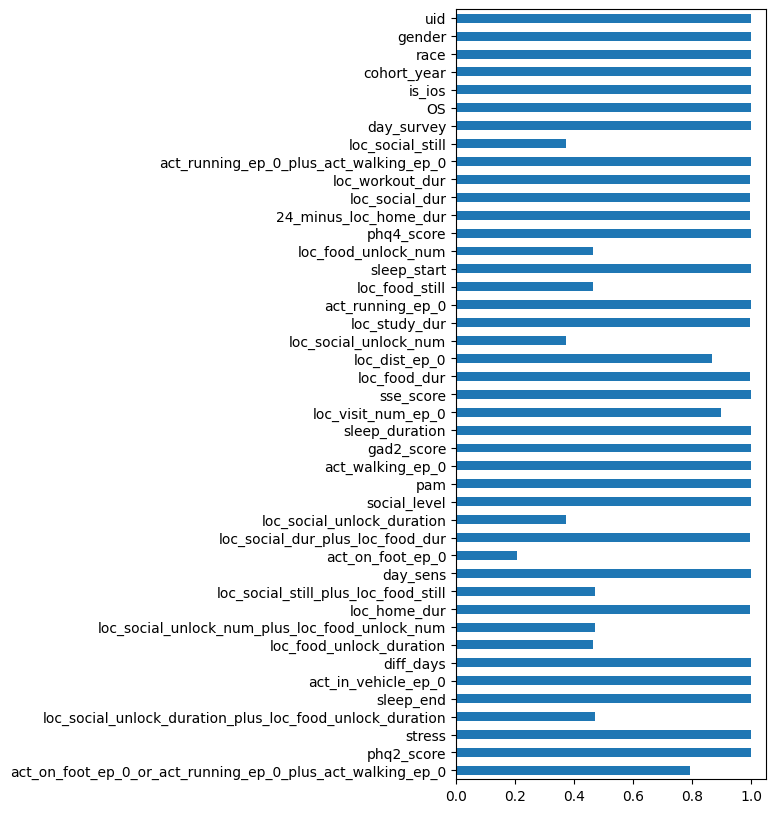

In [46]:
# null rate
ax = (
    (1 - df.isnull().mean())
    .to_frame()
    .plot.barh(figsize=(4, 10), legend=False)
)
ax.invert_yaxis()

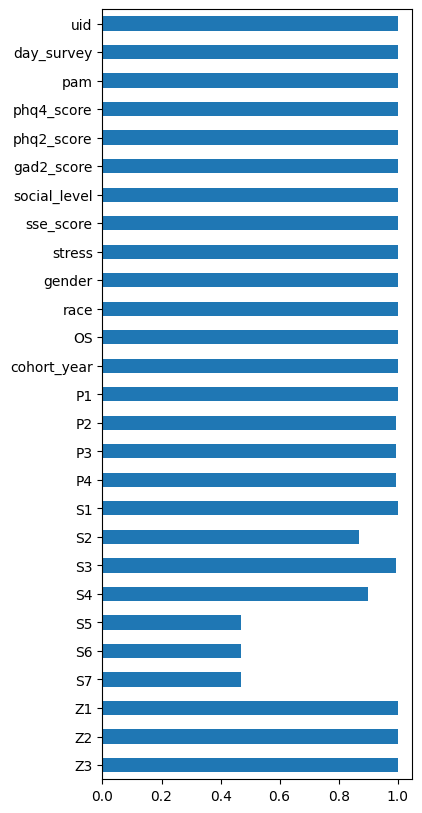

In [47]:
# null rate (after adding)
ax = (
    (1 - df_features.isnull().mean())
    .to_frame()
    .plot.barh(figsize=(4, 10), legend=False)
)
ax.invert_yaxis()

In [48]:
check_df = pd.read_csv("features.csv")
check_df

,uid,day_survey,pam,phq4_score,phq2_score,gad2_score,social_level,sse_score,stress,gender,...,S1,S2,S3,S4,S5,S6,S7,Z1,Z2,Z3
0,003df5deff30e1e5a07b5d063fe85c3f,2017-10-06,7.0,0.0,0.0,0.0,4.0,17.0,1.0,F,...,251.4,5314.150918,1.292778,5.75,12.981969,8.770523,56.938186,9.150,39.6,112.8
1,003df5deff30e1e5a07b5d063fe85c3f,2017-10-13,7.0,0.0,0.0,0.0,4.0,17.0,1.0,F,...,125.7,4846.948206,1.618000,5.40,6.255514,7.336248,65.683645,5.575,47.4,92.0
2,003df5deff30e1e5a07b5d063fe85c3f,2017-10-14,7.0,0.0,0.0,0.0,5.0,17.0,1.0,F,...,125.7,4713.753968,1.668028,5.40,5.581952,7.418661,62.666138,5.800,45.4,91.8
3,003df5deff30e1e5a07b5d063fe85c3f,2017-10-16,4.0,0.0,0.0,0.0,1.0,17.0,1.0,F,...,1540.6,43788.508496,1.305028,5.10,6.046236,6.195268,62.442725,5.500,41.8,85.8
4,003df5deff30e1e5a07b5d063fe85c3f,2017-10-23,1.0,0.0,0.0,0.0,3.0,17.0,2.0,F,...,1540.6,43090.361687,0.928583,4.80,15.476544,12.130441,60.148926,5.275,50.0,92.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34701,ffc4b142e017c162ed4db7b05414fc4b,2021-12-18,13.0,0.0,0.0,0.0,3.0,13.0,2.0,F,...,1703.6,8560.195186,0.000000,1.80,NaN,NaN,NaN,6.500,39.2,91.2
34702,ffc4b142e017c162ed4db7b05414fc4b,2021-12-31,4.0,0.0,0.0,0.0,3.0,12.0,3.0,F,...,821.0,13369.742485,0.000000,1.50,NaN,NaN,NaN,5.850,54.6,101.4
34703,ffc4b142e017c162ed4db7b05414fc4b,2022-01-27,3.0,1.0,1.0,0.0,3.0,12.0,5.0,F,...,13.9,3000.404831,1.951542,3.80,36.099785,8.703598,67.220218,6.350,48.2,99.0
34704,ffc4b142e017c162ed4db7b05414fc4b,2022-01-30,3.0,0.0,0.0,0.0,2.0,12.0,3.0,F,...,18.9,3131.680285,1.626057,3.60,41.777185,13.130987,66.991643,6.425,47.8,99.2
